In [3]:
%%writefile ../src/data_loader_preprocessor.py

import pandas as pd
import numpy as np
import logging
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.feature_selection import f_regression, SelectKBest
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

def load_data(file_path):
    try:
        data = pd.read_csv(file_path)
        logger.info(f"Data loaded. Shape: {data.shape}")
        return data
    except Exception as e:
        logger.error(f"Failed to load data from {file_path}: {e}")
        raise

def format_season(data):
    try:
        data['Season'] = data['Season'].apply(lambda x: int(x.split('-')[0]))
        logger.info(f"Seasons in data: {data['Season'].unique()}")
        return data
    except Exception as e:
        logger.error(f"Failed to format season data: {e}")
        raise

def clean_data(data):
    try:
        data_clean = data.copy()
        columns_to_drop = ['Injury_Periods', '2nd Apron', 'Wins', 'Losses']
        data_clean.drop(columns_to_drop, axis=1, errors='ignore', inplace=True)
        
        percentage_cols = ['3P%', '2P%', 'FT%', 'TS%']
        for col in percentage_cols:
            if col in data_clean.columns:
                data_clean[col] = data_clean[col].fillna(data_clean[col].mean())
        
        data_clean = data_clean.dropna()
        logger.info(f"Data cleaned. Remaining shape: {data_clean.shape}")
        return data_clean
    except Exception as e:
        logger.error(f"Failed to clean data: {e}")
        raise

def engineer_features(data):
    # Calculate per-game statistics to normalize performance data
    per_game_cols = ['PTS', 'AST', 'TRB', 'STL', 'BLK', 'TOV']
    for col in per_game_cols:
        data[f'{col[0]}PG'] = data[col] / data['GP']
    
    # Derive additional features to capture important aspects of a player's performance
    data['Availability'] = data['GP'] / 82
    data['SalaryPct'] = data['Salary'] / data['Salary_Cap_Inflated']
    data['Efficiency'] = (data['PTS'] + data['TRB'] + data['AST'] + data['STL'] + data['BLK']) / (data['FGA'] + data['FTA'] + data['TOV'] + 1)
    data['ValueOverReplacement'] = data['VORP'] / (data['Salary'] + 1)
    data['ExperienceSquared'] = data['Years of Service'] ** 2
    data['Days_Injured_Percentage'] = data['Total_Days_Injured'] / data['GP']
    data['WSPG'] = data['WS'] / data['GP']
    data['DWSPG'] = data['DWS'] / data['GP']
    data['OWSPG'] = data['OWS'] / data['GP']
    data['PFPG'] = data['PF'] / data['GP']
    data['ORPG'] = data['ORB'] / data['GP']
    data['DRPG'] = data['DRB'] / data['GP']
    
    # Drop columns used in feature creation or deemed less relevant
    columns_to_drop = ['GP', '2PA', 'OBPM', 'BPM', 'DBPM', '2P', 'GS', 'PTS', 'AST', 'TRB', 'STL', 'BLK',
                       'TOV', 'MP', 'FG', 'FGA', 'FG%', '3P', '3PA', '2P', '2PA', 'FT', 'FTA', 'ORB', 'DRB', 'TRB',
                       'TS%', 'ORB%', 'DRB%', 'TRB%', 'AST%', 'STL%', 'BLK%', 'TOV%', 'USG%', 'Luxury Tax', '1st Apron', 'BAE',
                       'Standard /Non-Taxpayer', 'Taxpayer', 'Team Room /Under Cap', 'WS', 'DWS', 'WS/48', 'PF', 'OWS', 'Injured']
    data.drop(columns_to_drop, axis=1, errors='ignore', inplace=True)
    print("New features added.")
    return data

def encode_injury_risk(data):
    # Encode injury risk levels for model training
    risk_mapping = {'Low': 0, 'Medium': 1, 'High': 2}
    data['Injury_Risk'] = data['Injury_Risk'].map(risk_mapping).fillna(0)  # Default to Low if unknown
    return data, risk_mapping

def encode_categorical(data, columns):
    # Encode categorical columns using one-hot encoding
    encoders = {}
    for col in columns:
        encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
        encoded = encoder.fit_transform(data[[col]])
        encoded_df = pd.DataFrame(encoded, columns=encoder.get_feature_names_out([col]), index=data.index)
        data = pd.concat([data.drop(col, axis=1), encoded_df], axis=1)
        encoders[col] = encoder
    return data, encoders


def encode_data(data, encoders=None, player_encoder=None):
    print("Columns before encoding:", data.columns)

    # Encode Injury_Risk
    risk_mapping = {'Low': 0, 'Medium': 1, 'High': 2}
    data['Injury_Risk'] = data['Injury_Risk'].map(risk_mapping).fillna(0)  # Default to Low if unknown

    # Encode Player column if it's present
    if 'Player' in data.columns:
        if player_encoder is None:
            player_encoder = LabelEncoder()
            data['Player_Encoded'] = player_encoder.fit_transform(data['Player'])
        else:
            data['Player_Encoded'] = player_encoder.transform(data['Player'])
        data.drop('Player', axis=1, inplace=True)  # Drop original Player column after encoding
    
    # Identify initial numeric columns
    initial_numeric_cols = data.select_dtypes(include=['int64', 'float64']).columns.tolist()

    # Encode categorical variables (excluding Season)
    categorical_cols = ['Position', 'Team']
    if encoders is None:
        encoders = {}
        for col in categorical_cols:
            encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')  # Updated line
            encoded = encoder.fit_transform(data[[col]])
            encoded_df = pd.DataFrame(encoded, columns=encoder.get_feature_names_out([col]), index=data.index)
            data = pd.concat([data.drop(col, axis=1), encoded_df], axis=1)
            encoders[col] = encoder
    else:
        for col in categorical_cols:
            encoded = encoders[col].transform(data[[col]])
            encoded_df = pd.DataFrame(encoded, columns=encoders[col].get_feature_names_out([col]), index=data.index)
            data = pd.concat([data.drop(col, axis=1), encoded_df], axis=1)

    # Identify final numeric columns (excluding one-hot encoded columns and 'Season')
    numeric_cols = [col for col in initial_numeric_cols if col not in ['Season', 'Injury_Risk', 'Player_Encoded']]

    # Scale numeric features (excluding 'Player_Encoded')
    scaler = StandardScaler()
    data[numeric_cols] = scaler.fit_transform(data[numeric_cols])

    print("Encoded data shape:", data.shape)
    print("Columns after encoding:", data.columns)

    return data, risk_mapping, encoders, scaler, numeric_cols, player_encoder



def scale_features(data, numeric_cols):
    scaler = StandardScaler()
    data[numeric_cols] = scaler.fit_transform(data[numeric_cols])
    return data, scaler

def decode_data(encoded_data, injury_risk_mapping, encoders, scaler, numeric_cols, player_encoder):
    decoded_data = encoded_data.copy()
    
    # Decode Injury_Risk
    inv_injury_risk_mapping = {v: k for k, v in injury_risk_mapping.items()}
    decoded_data['Injury_Risk'] = decoded_data['Injury_Risk'].map(inv_injury_risk_mapping)
    
    # Decode Player column
    if 'Player_Encoded' in decoded_data.columns:
        decoded_data['Player'] = player_encoder.inverse_transform(decoded_data['Player_Encoded'])
        decoded_data.drop('Player_Encoded', axis=1, inplace=True)
    
    # Decode categorical variables
    for col, encoder in encoders.items():
        encoded_cols = [c for c in decoded_data.columns if c.startswith(f"{col}_")]
        decoded_col = encoder.inverse_transform(decoded_data[encoded_cols])
        decoded_data[col] = decoded_col.ravel()  # Flatten the 2D array to 1D
        decoded_data.drop(encoded_cols, axis=1, inplace=True)
    
    # Inverse transform scaled features
    decoded_data[numeric_cols] = scaler.inverse_transform(decoded_data[numeric_cols])
    
    return decoded_data

def select_top_features(X, y, k=10):
    # Select top features based on statistical significance
    selector = SelectKBest(score_func=f_regression, k=k)
    selector.fit(X, y)
    top_features = X.columns[selector.get_support()].tolist()
    print(f"Top {k} features:", top_features)
    return top_features

def calculate_tree_feature_importance(X, y):
    # Calculate feature importance using a Random Forest Regressor
    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(X, y)
    importances = rf.feature_importances_
    feature_importances = pd.DataFrame({
        'Feature': X.columns,
        'Importance': importances
    }).sort_values(by='Importance', ascending=False)
    
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Feature', data=feature_importances.head(20))
    plt.title('Top 20 Feature Importances from Random Forest')
    plt.show()
    
    return feature_importances

if __name__ == "__main__":
    try:
        file_path = '../data/processed/nba_player_data_final_inflated.csv'
        data = load_data(file_path)
        data = format_season(data)
        data = clean_data(data)
        data = engineer_features(data)

        # Separate features and target
        X = data.drop(['SalaryPct', 'Salary'], axis=1)
        y = data['SalaryPct']

        # Encode data
        encoded_data, injury_risk_mapping, encoders, scaler, numeric_cols, player_encoder = encode_data(X)
        
        logger.info("Data preprocessing completed. Ready for model training.")
        

        print("\nInjury Risk Mapping:", injury_risk_mapping)
        print("Encoded Injury Risk range:", encoded_data['Injury_Risk'].min(), "-", encoded_data['Injury_Risk'].max())
        print("\nNumeric columns for scaling:", numeric_cols)

        # Calculate feature importance
        feature_importances = calculate_tree_feature_importance(encoded_data, y)
        print("\nTree-based feature importances:")
        print(feature_importances.head(20))

        # Select top features
        top_features = select_top_features(encoded_data, y)
        print("\nTop features selected using statistical methods:", top_features)

        # Decoding example
        print("\nDecoding Example:")
        decoded_data = decode_data(encoded_data, injury_risk_mapping, encoders, scaler, numeric_cols, player_encoder)
        
        print("\nFirst few rows of decoded data:")
        print(decoded_data[['Player', 'Injury_Risk', 'Position', 'Team', 'Season'] + top_features].head())

        print("\nData types after decoding:")
        print(decoded_data.dtypes)

        print("\nData preprocessing completed. Ready for model training.")
        
    except Exception as e:
        logger.critical(f"Critical error in data processing pipeline: {e}")
        raise

Overwriting ../src/data_loader_preprocessor.py


In [4]:
# %%writefile ../src/model_trainer.py
import joblib
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV
import pandas as pd
import numpy as np

def inspect_data_types(X):
    print("Data types of features:")
    print(X.dtypes)
    object_columns = X.select_dtypes(include=['object']).columns
    if not object_columns.empty:
        print("Columns with object data types:", object_columns.tolist())
    else:
        print("No columns with object data types.")

def perform_grid_search(model, param_grid, X_train, y_train):
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    print(f"Best parameters for {model.__class__.__name__}: {grid_search.best_params_}")
    print(f"Best score for {model.__class__.__name__}: {-grid_search.best_score_}")
    return grid_search.best_estimator_

def train_and_save_models(X_train, y_train, model_save_path, scaler, feature_names, encoders, player_encoder, numeric_cols):
    # Inspect data types before training
    inspect_data_types(X_train)

    # Initialize models with default parameters
    rf_model = RandomForestRegressor(random_state=42)
    xgb_model = xgb.XGBRegressor(random_state=42, enable_categorical=True)

    # Define parameter grids for grid search
    rf_param_grid = {
        'n_estimators': [100, 200, 300],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5, 10]
    }
    xgb_param_grid = {
        'n_estimators': [100, 200, 300],
        'max_depth': [3, 6, 9],
        'learning_rate': [0.01, 0.1, 0.2]
    }

    # Perform grid search
    best_rf_model = perform_grid_search(rf_model, rf_param_grid, X_train, y_train)
    best_xgb_model = perform_grid_search(xgb_model, xgb_param_grid, X_train, y_train)

    # Train models with best parameters
    best_rf_model.fit(X_train, y_train)
    best_xgb_model.fit(X_train, y_train)

    # Scale the features used for training
    X_train_scaled = scaler.fit_transform(X_train)

    # Save models, scaler, feature names, encoders, and other artifacts
    joblib.dump(best_rf_model, f"{model_save_path}/best_rf_model.pkl")
    joblib.dump(best_xgb_model, f"{model_save_path}/best_xgb_model.pkl")
    joblib.dump(scaler, f"{model_save_path}/scaler.pkl")
    joblib.dump(feature_names, f"{model_save_path}/feature_names.pkl")
    joblib.dump(encoders, f"{model_save_path}/encoders.pkl")
    joblib.dump(injury_risk_mapping, f"{model_save_path}/injury_risk_mapping.pkl")
    joblib.dump(numeric_cols, f"{model_save_path}/numeric_cols.pkl")

    joblib.dump(player_encoder, f"{model_save_path}/player_encoder.pkl")
    print("Models, scaler, feature names, encoders, and other artifacts trained and saved successfully.")

def evaluate_models(X_test, y_test, model_save_path):
    # Load models, scaler, and feature names
    rf_model = joblib.load(f"{model_save_path}/best_rf_model.pkl")
    xgb_model = joblib.load(f"{model_save_path}/best_xgb_model.pkl")

    # Make predictions
    rf_predictions = rf_model.predict(X_test)
    xgb_predictions = xgb_model.predict(X_test)

    # Evaluate models using multiple metrics
    metrics = {'Random Forest': rf_predictions, 'XGBoost': xgb_predictions}

    for model_name, predictions in metrics.items():
        mse = mean_squared_error(y_test, predictions)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_test, predictions)
        r2 = r2_score(y_test, predictions)

        print(f"\n{model_name} Evaluation:")
        print(f"MSE: {mse}")
        print(f"RMSE: {rmse}")
        print(f"MAE: {mae}")
        print(f"R-squared: {r2}")
        
def filter_seasons(data, predict_season):
    """
    Filters the dataset into prior seasons and the target season for prediction.

    Args:
        data (pd.DataFrame): The dataset containing season data.
        predict_season (int): The season that you want to predict.

    Returns:
        tuple: A tuple containing two DataFrames:
            - prior_seasons_data: Data for seasons before the predict_season.
            - target_season_data: Data for the predict_season.
    """
    # Separate data into prior seasons and the target season
    prior_seasons_data = data[data['Season'] < predict_season]
    target_season_data = data[data['Season'] == predict_season]
    
    print(f"Data filtered. Prior seasons shape: {prior_seasons_data.shape}, Target season shape: {target_season_data.shape}")
    
    return target_season_data, prior_seasons_data

# Data preprocessing
def load_and_preprocess_data(file_path, predict_season):
    data = load_data(file_path)
    data = format_season(data)
    _, prior_seasons_data = filter_seasons(data, predict_season)
    prior_seasons_data = clean_data(prior_seasons_data)
    prior_seasons_data = engineer_features(prior_seasons_data)
    return prior_seasons_data

# Feature selection
def select_features(data, target_column, additional_features=[]):
    top_features = ['PPG', 'APG', 'RPG', 'SPG', 'TOPG', 'Years of Service', 'PER', 'VORP', 'WSPG', 'OWSPG']
    
    # Add 'Injury_Risk', 'Position', and 'Team' to ensure they're included for encoding
    top_features += ['Injury_Risk', 'Position', 'Team']
    
    # Add any additional features
    top_features += additional_features
    
    # Ensure all selected features are in the dataset
    available_features = [col for col in top_features if col in data.columns]
    
    print("Available features for modeling:", available_features)  # Debug statement

    X = data[available_features]
    y = data[target_column]
    return X, y

# Main execution
# if __name__ == "__main__":
#     file_path = 'data/processed/nba_player_data_final_inflated.csv'
#     predict_season = 2023
#     target_column = 'SalaryPct'

#     # Load and preprocess data
#     preprocessed_data = load_and_preprocess_data(file_path, predict_season)
#     print("Columns after preprocessing:", preprocessed_data.columns)

#     # Select features
#     X, y = select_features(preprocessed_data, target_column)
#     print("Columns after feature selection:", X.columns)

#     # Encode data
#     encoded_data, injury_risk_mapping, encoders, scaler, numeric_cols, player_encoder = encode_data(X)
#     print("Columns after encoding:", encoded_data.columns)

#     # Split the data
#     X_train, X_test, y_train, y_test = train_test_split(encoded_data, y, test_size=0.2, random_state=42)

#     # Train and evaluate models
#     model_save_path = 'data/models'
#     train_and_save_models(X_train, y_train, model_save_path, scaler, encoded_data.columns, encoders, injury_risk_mapping, numeric_cols)
#     evaluate_models(X_test, y_test, model_save_path)


In [5]:
%%writefile ../src/model_predictor.py

import joblib
import pandas as pd

def load_models_and_utils(model_save_path):
    rf_model = joblib.load(f"{model_save_path}/best_rf_model.pkl")
    xgb_model = joblib.load(f"{model_save_path}/best_xgb_model.pkl")
    scaler = joblib.load(f"{model_save_path}/scaler.pkl")
    feature_names = joblib.load(f"{model_save_path}/feature_names.pkl")
    encoders = joblib.load(f"{model_save_path}/encoders.pkl")
    injury_risk_mapping = joblib.load(f"{model_save_path}/injury_risk_mapping.pkl")
    numeric_cols = joblib.load(f"{model_save_path}/numeric_cols.pkl")
    player_encoder = joblib.load(f"{model_save_path}/player_encoder.pkl")
    return rf_model, xgb_model, scaler, feature_names, encoders, injury_risk_mapping, numeric_cols, player_encoder

def predict(data, model_save_path):
    rf_model, xgb_model, scaler, feature_names, encoders, _, _, player_encoder = load_models_and_utils(model_save_path)
    
    print("Original data shape:", data.shape)
    print("Original data columns:", data.columns.tolist())

    # Preserve player names
    player_names = data['Player'] if 'Player' in data.columns else None
    
    # Drop the player column before encoding
    data = data.drop(columns=['Player'], errors='ignore')
    
    # Encode the data using the loaded encoders
    encoded_data, _, _, _, _, _ = encode_data(data, encoders, player_encoder)
    
    print("Encoded data shape:", encoded_data.shape)
    print("Encoded data columns:", encoded_data.columns.tolist())
    
    # Handle missing features: Add missing columns and set them to zero
    for col in feature_names:
        if col not in encoded_data.columns:
            encoded_data[col] = 0

    # Ensure encoded_data only has feature_names columns
    encoded_data = encoded_data[feature_names]
    
    print("Selected features shape:", encoded_data.shape)
    print("Selected features:", encoded_data.columns.tolist())
    print("Expected features:", feature_names)
    
    # Scale the encoded data
    encoded_data_scaled = scaler.transform(encoded_data)
    
    # Make predictions
    rf_predictions = rf_model.predict(encoded_data_scaled)
    xgb_predictions = xgb_model.predict(encoded_data_scaled)
    
    # Create a DataFrame for predictions
    predictions_df = pd.DataFrame({
        'RF_Predictions': rf_predictions,
        'XGB_Predictions': xgb_predictions,
        'Predicted_Salary': (rf_predictions + xgb_predictions) / 2
    })
    
    # Attach player names back to the predictions
    if player_names is not None:
        predictions_df['Player'] = player_names.values

    # Combine the predictions with the original data (excluding player names)
    result = pd.concat([data.reset_index(drop=True), predictions_df], axis=1)

    return result


if __name__ == "__main__":
    file_path = 'data/processed/nba_player_data_final_inflated.csv'
    predict_season = 2023
    data = load_data(file_path)
    data = format_season(data)
    current_season_data, _ = filter_seasons(data, predict_season)
    current_season_data = clean_data(current_season_data)
    current_season_data = engineer_features(current_season_data)
    model_save_path = 'data/models'
    predictions_df = predict(current_season_data, model_save_path)  # Save predictions as predictions_df
    print(predictions_df.head())
    
    # Save predictions_df for later use
    predictions_df.to_csv('data/processed/predictions_df.csv', index=False)


Overwriting ../src/model_predictor.py


https://www.hoopsrumors.com/2023/09/salary-matching-rules-for-trades-during-2023-24-season.html

for trade rules


FIRST_TAX_APRON = 172_346_000

def check_salary_matching_rules(outgoing_salary, incoming_salary, team_salary_before_trade):
    if team_salary_before_trade < FIRST_TAX_APRON:
        if outgoing_salary <= 7_500_000:
            max_incoming_salary = 2 * outgoing_salary + 250_000
        elif outgoing_salary <= 29_000_000:
            max_incoming_salary = outgoing_salary + 7_500_000
        else:
            max_incoming_salary = 1.25 * outgoing_salary + 250_000
    else:
        max_incoming_salary = 1.10 * outgoing_salary

    return incoming_salary <= max_incoming_salary

In [6]:
%%writefile ../src/percentile_count_trade_impact.py

import pandas as pd
import numpy as np
import time
from nba_api.stats.endpoints import leaguegamefinder, playergamelogs
from nba_api.stats.static import teams, players

# Constants
RELEVANT_STATS = ['PTS', 'AST', 'TOV', 'STL', 'BLK', 'OREB', 'DREB', 'FGM', 'FG3M', 'FGA']
PERCENTILE_THRESHOLDS = [1, 2, 3, 4, 5, 10, 25, 50]

def load_team_data():
    nba_teams = teams.get_teams()
    team_df = pd.DataFrame(nba_teams)
    return team_df[['id', 'full_name', 'abbreviation']]

# Helper Functions

def fetch_player_id_by_name(player_name, debug=False):
    """Fetch player ID based on player name."""
    try:
        player = players.find_players_by_full_name(player_name)[0]
        if debug:
            print(f"Fetched ID for player {player_name}: {player['id']}")
        return player['id']
    except Exception as e:
        if debug:
            print(f"Error fetching ID for player {player_name}: {e}")
        return None

def get_champion_for_percentile(season, debug=False):
    """Fetch the champion team for a given NBA season."""
    try:
        games = leaguegamefinder.LeagueGameFinder(season_nullable=season, season_type_nullable='Playoffs').get_data_frames()[0]
        games['GAME_DATE'] = pd.to_datetime(games['GAME_DATE'])
        last_game = games.sort_values('GAME_DATE').iloc[-2:]
        winner = last_game[last_game['WL'] == 'W'].iloc[0]
        if debug:
            print(f"Champion for season {season}: {winner['TEAM_NAME']} ({winner['TEAM_ID']})")
        return winner['TEAM_NAME']
    except Exception as e:
        if debug:
            print(f"Error fetching champion for season {season}: {e}")
        return None

def get_champions_for_percentile(start_year, end_year, debug=False):
    """Fetch champions for each season from start_year to end_year."""
    champions = []
    for year in range(start_year, end_year + 1):
        season = f"{year}-{str(year+1)[-2:]}"
        champ_name = get_champion_for_percentile(season, debug)
        if champ_name:
            champions.append({'Season': season, 'ChampionTeamName': champ_name})
        elif debug:
            print(f"Champion data not available for season {season}")
        time.sleep(1)  # To avoid overwhelming the API
    if debug:
        print(f"Champions data: {champions}")
    return pd.DataFrame(champions)

def calculate_average_top_percentiles(top_percentile_counts_df, debug=False):
    """Calculate the average percentiles for all champion teams, grouped by season."""
    average_percentiles = {}

    for col in RELEVANT_STATS:
        for threshold in PERCENTILE_THRESHOLDS:
            count_key = f'{col}_Top_{threshold}_count'
            avg_key = f'{col}_Avg_Top_{threshold}_percentile'
            
            # Calculate the mean of counts grouped by 'Season' and then average these means
            avg_value = top_percentile_counts_df.groupby('Season')[count_key].mean().mean()
            
            avg_value = avg_value if pd.notnull(avg_value) else 0
            average_percentiles[avg_key] = avg_value
            
            if debug:
                print(f"{col} Avg Top {threshold}% Count across seasons: {avg_value}")
    
    return pd.DataFrame([average_percentiles])


def calculate_champion_percentiles(league_percentiles, champions, debug=False):
    """Extract percentiles for players in champion teams based on league percentiles."""
    champion_data = league_percentiles[league_percentiles['TEAM_NAME'].isin(champions['ChampionTeamName'])].copy()
    
    # Merge with champions to get the Season associated with each champion team
    champion_data = pd.merge(champion_data, champions, left_on='TEAM_NAME', right_on='ChampionTeamName')
    
    if debug:
        print("Champion Data Percentiles with Season:")
        print(champion_data[['TEAM_NAME', 'Season', 'PLAYER_NAME']].head())
    
    return champion_data


def fetch_all_player_data(seasons, debug=False):
    """Fetch player game logs data for all players across multiple seasons."""
    all_data = pd.DataFrame()
    for season in seasons:
        try:
            player_logs = playergamelogs.PlayerGameLogs(season_nullable=season).get_data_frames()[0]
            player_logs['SEASON'] = season
            all_data = pd.concat([all_data, player_logs], ignore_index=True)
            if debug:
                print(f"Fetched {len(player_logs)} player logs for the league in season {season}")
        except Exception as e:
            if debug:
                print(f"Error fetching player data for the league in season {season}: {e}")
    if debug:
        print(f"Total logs fetched: {len(all_data)}")
    return all_data

def calculate_player_stats(player_data, debug=False):
    """Calculate average player statistics from game logs."""
    # Calculate stats per game for players
    player_stats = player_data.groupby(['SEASON', 'TEAM_NAME', 'PLAYER_NAME'])[RELEVANT_STATS].mean().reset_index()
    
    # Rename columns to include '_per_game'
    for stat in RELEVANT_STATS:
        player_stats.rename(columns={stat: f'{stat}_per_game'}, inplace=True)

    if debug:
        print("Sample player stats (entire league):")
        print(player_stats.head())  # Show head of the player stats
    return player_stats

def calculate_player_percentiles(stats_df, debug=False):
    """Calculate percentile ranks for each stat in the DataFrame by season."""
    percentiles = {}

    for col in RELEVANT_STATS:
        col_per_game = f'{col}_per_game'
        if col_per_game in stats_df.columns:
            # Calculate percentiles across the entire dataset
            stats_df[f'{col}_percentile'] = stats_df[col_per_game].rank(pct=True, method='min')
            # Ensure no NaN values before calculating percentiles
            if not stats_df[col_per_game].isna().any():
                percentiles[col] = np.percentile(stats_df[col_per_game], [100 - t for t in PERCENTILE_THRESHOLDS])
            else:
                if debug:
                    print(f"NaN values found in {col_per_game} column.")
            if debug:
                print(f"Calculated percentiles for {col_per_game}:")
                print(stats_df[['TEAM_NAME', 'PLAYER_NAME', col_per_game, f'{col}_percentile']].head())
    return stats_df, percentiles

def count_top_percentiles(player_percentiles, percentiles, team_name, season, debug=False):
    """Count how many players in a specific team fall within top percentiles, filtered by season."""
    top_counts = {f'{stat}_Top_{threshold}_count': 0 for stat in RELEVANT_STATS for threshold in PERCENTILE_THRESHOLDS}
    
    # Filter the data by team and season
    team_data = player_percentiles[(player_percentiles['TEAM_NAME'] == team_name) & (player_percentiles['SEASON'] == season)]
    
    if debug:
        print(f"\n{team_name} player percentiles data for season {season}:\n{team_data[['PLAYER_NAME', 'FG3M_per_game', 'FG3M_percentile']]}")
    
    for col in RELEVANT_STATS:
        col_per_game = f'{col}_per_game'
        if col in percentiles:  # Ensure we have valid percentiles calculated
            for idx, threshold in enumerate(PERCENTILE_THRESHOLDS):
                count_key = f'{col}_Top_{threshold}_count'
                top_counts[count_key] = (team_data[col_per_game] >= percentiles[col][idx]).sum()

                if debug and col == 'FG3M':
                    print(f"{col} Top {threshold}% Count for season {season}: {top_counts[count_key]}")
                    print(f"Players in Top {threshold}% for {col} in season {season}: {team_data[team_data[col_per_game] >= percentiles[col][idx]][['PLAYER_NAME', col_per_game, f'{col}_percentile']]}")

    return top_counts


def simulate_trade(player_stats, players_from_team_a, players_from_team_b, team_a_name, team_b_name, debug=False):
    """Simulate a trade by swapping players between two teams."""
    if debug:
        print("\nBefore trade simulation:")
        print(player_stats[(player_stats['PLAYER_NAME'].isin(players_from_team_a + players_from_team_b))][['PLAYER_NAME', 'TEAM_NAME']])
    
    # Swap players between the two teams
    player_stats.loc[player_stats['PLAYER_NAME'].isin(players_from_team_a), 'TEAM_NAME'] = team_b_name
    player_stats.loc[player_stats['PLAYER_NAME'].isin(players_from_team_b), 'TEAM_NAME'] = team_a_name
    
    if debug:
        print("\nAfter trade simulation:")
        print(player_stats[(player_stats['PLAYER_NAME'].isin(players_from_team_a + players_from_team_b))][['PLAYER_NAME', 'TEAM_NAME']])
    
    return player_stats

def create_comparison_table(before_trade, after_trade, average_percentiles, team_name):
    """Create a comparison table for a team before and after the trade."""
    data = {'Team': [team_name] * len(PERCENTILE_THRESHOLDS), 'Percentile': PERCENTILE_THRESHOLDS}
    
    for stat in RELEVANT_STATS:
        before_counts = [before_trade[f'{stat}_Top_{threshold}_count'] for threshold in PERCENTILE_THRESHOLDS]
        after_counts = [after_trade[f'{stat}_Top_{threshold}_count'] for threshold in PERCENTILE_THRESHOLDS]
        champ_avg = [average_percentiles[f'{stat}_Avg_Top_{threshold}_percentile'][0] for threshold in PERCENTILE_THRESHOLDS]
        
        data[f'{stat}_Before'] = before_counts
        data[f'{stat}_After'] = after_counts
        data[f'{stat}_Champ_Avg'] = champ_avg
    
    df = pd.DataFrame(data)
    df.set_index('Percentile', inplace=True)
    return df

def fetch_and_process_season_data(seasons, debug=False):
    # Fetch player data for all specified seasons
    all_player_data = fetch_all_player_data(seasons, debug)
    
    # Calculate player-level stats
    player_stats = calculate_player_stats(all_player_data, debug)
    
    # Calculate percentiles for all players in the league
    league_percentiles, league_percentiles_ref = calculate_player_percentiles(player_stats, debug)
    
    return player_stats, league_percentiles, league_percentiles_ref

def get_champion_percentiles(seasons, debug=False):
    start_year = int(seasons[0].split('-')[0])
    end_year = int(seasons[-1].split('-')[0])

    champion_info = get_champions_for_percentile(start_year, end_year, debug)
    player_stats, league_percentiles, league_percentiles_ref = fetch_and_process_season_data(seasons, debug)
    
    # Calculate champion percentiles including the Season column
    champion_percentiles = calculate_champion_percentiles(league_percentiles, champion_info, debug)
    
    # Group by TEAM_NAME and Season, then calculate top percentiles
    top_percentile_counts = champion_percentiles.groupby(['TEAM_NAME', 'Season']).apply(
        lambda x: count_top_percentiles(x, league_percentiles_ref, x.iloc[0]['TEAM_NAME'], x.iloc[0]['Season'], debug)
    ).apply(pd.Series).reset_index()

    # Calculate average percentiles across all seasons for each champion team
    average_top_percentiles_df = calculate_average_top_percentiles(top_percentile_counts, debug)
    
    return average_top_percentiles_df


def compare_teams_before_after_trade(season, team_a_name, team_b_name, players_from_team_a, players_from_team_b, debug=False):
    player_stats, league_percentiles, league_percentiles_ref = fetch_and_process_season_data([season], debug)
    
    # Count top percentiles before the trade
    team_a_top_percentile_counts = count_top_percentiles(league_percentiles, league_percentiles_ref, team_a_name, season, debug)
    team_b_top_percentile_counts = count_top_percentiles(league_percentiles, league_percentiles_ref, team_b_name, season, debug)
    
    # Simulate the trade
    player_stats = simulate_trade(player_stats, players_from_team_a, players_from_team_b, team_a_name, team_b_name, debug)
    
    # Recalculate percentiles after the trade
    league_percentiles_after_trade, _ = calculate_player_percentiles(player_stats, debug)
    
    if debug:
        print("\nAfter trade percentiles calculation:")
        print(league_percentiles_after_trade[['TEAM_NAME', 'PLAYER_NAME', 'FG3M_per_game', 'FG3M_percentile']])
    
    # Count top percentiles after the trade
    team_a_top_percentile_counts_after = count_top_percentiles(league_percentiles_after_trade, league_percentiles_ref, team_a_name, season, debug)
    team_b_top_percentile_counts_after = count_top_percentiles(league_percentiles_after_trade, league_percentiles_ref, team_b_name, season, debug)
    
    return team_a_top_percentile_counts, team_a_top_percentile_counts_after, team_b_top_percentile_counts, team_b_top_percentile_counts_after


def generate_comparison_tables(season, team_a_name, team_b_name, players_from_team_a, players_from_team_b, average_top_percentiles_df, debug=False):
    team_a_top_before, team_a_top_after, team_b_top_before, team_b_top_after = compare_teams_before_after_trade(
        season, team_a_name, team_b_name, players_from_team_a, players_from_team_b, debug
    )
    
    # Create comparison tables with champion average percentiles
    celtics_comparison_table = create_comparison_table(team_a_top_before, team_a_top_after, average_top_percentiles_df, team_a_name)
    warriors_comparison_table = create_comparison_table(team_b_top_before, team_b_top_after, average_top_percentiles_df, team_b_name)
    
    return celtics_comparison_table, warriors_comparison_table


def main(debug=False):
    seasons = ["2019-20", "2020-21","2021-22", "2022-23", "2023-24"]

    # Fetch champion percentiles and calculate averages
    average_top_percentiles_df = get_champion_percentiles(seasons, debug)
    
    if debug:
        print("\nAverage Champion Percentiles:")
        print(average_top_percentiles_df)
    
    team_a_name = "Boston Celtics"
    team_b_name = "Golden State Warriors"
    players_from_boston = ["Jaylen Brown", "Jayson Tatum"]
    players_from_warriors = ["Jordan Poole", "Kevon Looney"]
    
    # Generate comparison tables before and after the trade
    celtics_comparison_table, warriors_comparison_table = generate_comparison_tables(
        seasons[-1], team_a_name, team_b_name, players_from_boston, players_from_warriors, average_top_percentiles_df, debug
    )
    
    # Display tables
    print("\nBoston Celtics Comparison Table:")
    print(celtics_comparison_table)
    
    print("\nGolden State Warriors Comparison Table:")
    print(warriors_comparison_table)

if __name__ == "__main__":
    main(debug=True)




Overwriting ../src/percentile_count_trade_impact.py


In [7]:
%%writefile ../src/overall_team_trade_impact.py

import pandas as pd
import numpy as np
from nba_api.stats.endpoints import playergamelogs, leaguegamefinder
from tabulate import tabulate
import time
from nba_api.stats.endpoints import commonplayerinfo
from nba_api.stats.static import teams, players

# Constants
RELEVANT_STATS = ['PTS', 'AST', 'TOV', 'STL', 'BLK', 'OREB', 'DREB', 'FGM', 'FG3M', 'FGA']

def load_team_data():
    nba_teams = teams.get_teams()
    team_df = pd.DataFrame(nba_teams)
    return team_df[['id', 'full_name', 'abbreviation']]

def fetch_player_id_by_name(player_name, debug=False):
    """Fetch player ID based on player name."""
    try:
        player = players.find_players_by_full_name(player_name)[0]
        if debug:
            print(f"Fetched ID for player {player_name}: {player['id']}")
        return player['id']
    except Exception as e:
        if debug:
            print(f"Error fetching ID for player {player_name}: {e}")
        return None

def fetch_player_info(player_id, debug=False):
    """Fetch player information based on player ID."""
    try:
        player_info = commonplayerinfo.CommonPlayerInfo(player_id=player_id).get_data_frames()[0]
        if debug:
            print(f"Fetched info for player ID {player_id}: {player_info['DISPLAY_FIRST_LAST'].values[0]}")
        return player_info
    except Exception as e:
        if debug:
            print(f"Error fetching info for player ID {player_id}: {e}")
        return None

def fetch_season_data_by_year(year):
    """Fetch player game logs data for a given starting year of the NBA season."""
    season = f"{year}-{str(year+1)[-2:]}"
    player_logs = playergamelogs.PlayerGameLogs(season_nullable=season).get_data_frames()[0]
    player_logs['SEASON'] = season
    player_logs['GAME_DATE'] = pd.to_datetime(player_logs['GAME_DATE'])
    return player_logs

def calculate_team_averages(season_data):
    """Calculate team averages for the relevant stats."""
    team_stats = (
        season_data.groupby(['SEASON', 'TEAM_NAME'])[RELEVANT_STATS]
        .sum()
        .reset_index()
    )
    games_played = season_data.groupby(['SEASON', 'TEAM_NAME'])['GAME_ID'].nunique().reset_index(name='GAMES_PLAYED')
    team_stats = pd.merge(team_stats, games_played, on=['SEASON', 'TEAM_NAME'])

    for stat in RELEVANT_STATS:
        team_stats[f'{stat}_per_game'] = team_stats[stat] / team_stats['GAMES_PLAYED']
    
    team_stats['eFG%_per_game'] = (
        (team_stats['FGM_per_game'] + 0.5 * team_stats['FG3M_per_game']) / team_stats['FGA_per_game']
    )
    
    return team_stats

def calculate_percentiles(stats_df, debug=False):
    """Calculate percentiles for the stats within each season."""
    for season in stats_df['SEASON'].unique():
        season_data = stats_df[stats_df['SEASON'] == season]
        for stat in RELEVANT_STATS + ['eFG%']:
            stat_per_game = f'{stat}_per_game'
            if stat_per_game in season_data.columns:
                stats_df.loc[season_data.index, f'{stat}_percentile'] = season_data[stat_per_game].rank(pct=True)
                if debug:
                    print(f"Calculated percentiles for {stat} in season {season}:")
                    print(stats_df.loc[season_data.index, [stat_per_game, f'{stat}_percentile']].head())
    return stats_df

def get_champion(season, debug=False):
    """Fetch the champion team for a given NBA season."""
    try:
        games = leaguegamefinder.LeagueGameFinder(season_nullable=season, season_type_nullable='Playoffs').get_data_frames()[0]
        games['GAME_DATE'] = pd.to_datetime(games['GAME_DATE'])
        last_game = games.sort_values('GAME_DATE').iloc[-2:]
        winner = last_game[last_game['WL'] == 'W'].iloc[0]
        if debug:
            print(f"Champion for season {season}: {winner['TEAM_NAME']} ({winner['TEAM_ID']})")
        return winner['TEAM_NAME']
    except Exception as e:
        if debug:
            print(f"Error fetching champion for season {season}: {e}")
        return None

def get_champions(start_year, end_year, debug=False):
    """Fetch champions for each season from start_year to end_year."""
    champions = {}
    for year in range(start_year, end_year + 1):
        season = f"{year}-{str(year+1)[-2:]}"
        champ_name = get_champion(season, debug)
        if champ_name:
            champions[season] = {'ChampionTeamName': champ_name}
        elif debug:
            print(f"Champion data not available for season {season}")
        time.sleep(1)  # To avoid overwhelming the API
    if debug:
        print(f"Champions data: {champions}")
    return champions

def get_champion_team_stats(start_year, end_year):
    """Fetch and process champion team stats for the given range of years."""
    all_team_stats = pd.DataFrame()

    for year in range(start_year, end_year + 1):
        season_data = fetch_season_data_by_year(year)
        team_stats = calculate_team_averages(season_data)
        team_stats = calculate_percentiles(team_stats)
        
        # Identify the champion team
        champ_name = get_champion(f"{year}-{str(year+1)[-2:]}")
        if champ_name:
            champ_stats = team_stats[team_stats['TEAM_NAME'] == champ_name]
            all_team_stats = pd.concat([all_team_stats, champ_stats])

    # Calculate the average stats for the champions (only numeric columns)
    numeric_cols = all_team_stats.select_dtypes(include=[np.number]).columns
    avg_stats = all_team_stats[numeric_cols].mean()

    # Create a DataFrame for the average stats and append to the results
    avg_stats_df = pd.DataFrame([avg_stats])
    avg_stats_df['SEASON'] = 'Average'
    avg_stats_df['TEAM_NAME'] = 'Average Champion'
    
    # Append the average row to the champion team data
    all_team_stats = pd.concat([all_team_stats, avg_stats_df], ignore_index=True)
    
    return all_team_stats

def calculate_team_stats(player_data, period, debug=False):
    """Calculate team-level statistics, including averages."""
    if debug:
        print(f"Calculating {period} team-level statistics.")
        print("Initial player_data head:")
        print(player_data.head())

    # Calculate team-level stats by summing player stats for each team and season
    team_stats = (
        player_data.groupby(['SEASON', 'TEAM_NAME'])[RELEVANT_STATS]
        .sum()
        .reset_index()
    )

    # Calculate the number of games played by each team
    games_played = player_data.groupby(['SEASON', 'TEAM_NAME'])['GAME_ID'].nunique().reset_index(name='GAMES_PLAYED')

    # Merge games played with team stats
    team_stats = pd.merge(team_stats, games_played, on=['SEASON', 'TEAM_NAME'])

    # Calculate stats per game
    for stat in RELEVANT_STATS:
        team_stats[f'{stat}_per_game'] = team_stats[stat] / team_stats['GAMES_PLAYED']

    # Add period column
    team_stats['PERIOD'] = period

    if debug:
        print(f"{period} team-level statistics head:")
        print(team_stats.head())

    return team_stats

def calculate_post_trade_team_stats(player_data, traded_players, trade_date, season_data, debug=False):
    """Calculate post-trade team-level statistics, using entire season if necessary."""
    if debug:
        print("Calculating post-trade team-level statistics.")

    # Convert trade_date to datetime
    trade_date = pd.to_datetime(trade_date)

    # Determine the start of the season based on the SEASON column
    season_start_year = int(player_data['SEASON'].iloc[0].split('-')[0])
    season_start_date = pd.to_datetime(f"{season_start_year}-10-01")  # NBA season typically starts in October

    # Determine whether to use entire season data or data after trade date
    if trade_date < season_start_date:
        if debug:
            print(f"Warning: Trade date {trade_date} is earlier than the start of the season {season_start_date}. Using entire season data.")
        post_trade_data = season_data  # Use the entire season data
    else:
        post_trade_data = player_data[player_data['GAME_DATE'] >= trade_date].copy()

    if debug:
        print("Post-trade player data head:")
        print(post_trade_data.head())

    # Calculate post-trade stats
    post_trade_stats = calculate_team_stats(post_trade_data, 'Post-trade', debug)

    # Calculate traded players' post-trade averages
    traded_player_stats = {}
    for player_name, new_team_name in traded_players.items():
        player_id = fetch_player_id_by_name(player_name, debug)
        player_post_trade_stats = post_trade_data[post_trade_data['PLAYER_ID'] == player_id][RELEVANT_STATS].mean()
        traded_player_stats[player_name] = player_post_trade_stats.to_dict()
        if debug:
            print(f"{player_name} averages post-trade (to {new_team_name}): {traded_player_stats[player_name]}")

    # Adjust post-trade stats based on traded players
    for player_name, new_team_name in traded_players.items():
        player_id = fetch_player_id_by_name(player_name, debug)
        old_team_name = player_data[player_data['PLAYER_ID'] == player_id]['TEAM_NAME'].iloc[0]
        post_trade_games = post_trade_stats.loc[post_trade_stats['TEAM_NAME'] == new_team_name, 'GAMES_PLAYED'].values[0]

        if debug:
            print(f"\nAdjusting stats for trade: {player_name} from {old_team_name} to {new_team_name}")

        # Remove player's stats from old team
        for stat in RELEVANT_STATS:
            # Ensure the column is a float before performing the operation
            post_trade_stats[stat] = post_trade_stats[stat].astype(float)
            if debug:
                print(f"  Before adjustment - {old_team_name} {stat}: {post_trade_stats.loc[post_trade_stats['TEAM_NAME'] == old_team_name, stat].values[0]}")
            post_trade_stats.loc[post_trade_stats['TEAM_NAME'] == old_team_name, stat] -= traded_player_stats[player_name][stat] * post_trade_games
            if debug:
                print(f"  After adjustment - {old_team_name} {stat}: {post_trade_stats.loc[post_trade_stats['TEAM_NAME'] == old_team_name, stat].values[0]}")

        # Add player's stats to new team
        for stat in RELEVANT_STATS:
            if debug:
                print(f"  Before adjustment - {new_team_name} {stat}: {post_trade_stats.loc[post_trade_stats['TEAM_NAME'] == new_team_name, stat].values[0]}")
            post_trade_stats.loc[post_trade_stats['TEAM_NAME'] == new_team_name, stat] += traded_player_stats[player_name][stat] * post_trade_games
            if debug:
                print(f"  After adjustment - {new_team_name} {stat}: {post_trade_stats.loc[post_trade_stats['TEAM_NAME'] == new_team_name, stat].values[0]}")

    # Recalculate per-game stats
    for stat in RELEVANT_STATS:
        post_trade_stats[f'{stat}_per_game'] = post_trade_stats[stat] / post_trade_stats['GAMES_PLAYED']

    if debug:
        print("Post-trade team stats calculated successfully.")
        print("Post-trade team stats head:")
        print(post_trade_stats.head())

    return post_trade_stats


def compare_team_performance(percentiles, champion_team_data, traded_teams, champion_filter='Average Champion', debug=False):
    """Generate a comparison table for team performance before and after trades."""
    if debug:
        print("Comparing team performance:")
        print("Percentiles data head:")
        print(percentiles.head())
    
    # Filter for the selected champion
    if champion_filter == 'Average Champion':
        champion_row = champion_team_data[champion_team_data['TEAM_NAME'] == 'Average Champion'].iloc[0]
    else:
        champion_row = champion_team_data[(champion_team_data['SEASON'] == champion_filter) & (champion_team_data['TEAM_NAME'] != 'Average Champion')].iloc[0]

    comparison_data = []
    
    for team in traded_teams:
        pre_trade_stats = percentiles[(percentiles['TEAM_NAME'] == team) & (percentiles['PERIOD'] == 'Pre-trade')]
        post_trade_stats = percentiles[(percentiles['TEAM_NAME'] == team) & (percentiles['PERIOD'] == 'Post-trade')]
        
        if not pre_trade_stats.empty and not post_trade_stats.empty:
            team_comparison = {'Team': team}
            for stat in RELEVANT_STATS + ['eFG%']:
                team_comparison[f'{stat} Pre-trade'] = pre_trade_stats[f'{stat}_per_game'].values[0]
                team_comparison[f'{stat} Pre-trade Percentile'] = pre_trade_stats[f'{stat}_percentile'].values[0]
                team_comparison[f'{stat} Post-trade'] = post_trade_stats[f'{stat}_per_game'].values[0]
                team_comparison[f'{stat} Post-trade Percentile'] = post_trade_stats[f'{stat}_percentile'].values[0]
                team_comparison[f'{stat} Champion'] = champion_row[f'{stat}_per_game']
                team_comparison[f'{stat} Champion Percentile'] = champion_row[f'{stat}_percentile']
            
            comparison_data.append(team_comparison)
        else:
            if debug:
                print(f"No data available for comparison for {team}.")
                print("Pre-trade stats head:")
                print(pre_trade_stats.head())
                print("Post-trade stats head:")
                print(post_trade_stats.head())

    comparison_df = pd.DataFrame(comparison_data)

    if debug:
        print("\nComparison Results:")
        print(tabulate(comparison_df, headers='keys', tablefmt='grid'))

    return comparison_df


def validate_post_trade_stats(player_data, trade_date, traded_teams, post_trade_stats, debug=False):
    """Validate the post-trade statistics calculation."""
    trade_date = pd.to_datetime(trade_date)
    post_trade_data = player_data[player_data['GAME_DATE'] >= trade_date]

    validation_results = {}

    for team in traded_teams:
        team_data = post_trade_data[post_trade_data['TEAM_NAME'] == team]
        
        total_points = team_data['PTS'].sum()
        games_played = team_data['GAME_ID'].nunique()
        calculated_ppg = total_points / games_played if games_played > 0 else 0

        reported_ppg = post_trade_stats[post_trade_stats['TEAM_NAME'] == team]['PTS_per_game'].values[0]

        validation_results[team] = {
            'Calculated PPG': calculated_ppg,
            'Reported PPG': reported_ppg,
            'Difference': calculated_ppg - reported_ppg,
            'Games Played': games_played
        }

    if debug:
        print("\nPost-Trade Statistics Validation:")
        print(tabulate(pd.DataFrame(validation_results).T, headers='keys', tablefmt='grid'))

    return validation_results

def fetch_and_process_champion_data(start_year, end_year, debug=False):
    """Fetch and process champion data for the given range of years."""
    champions = get_champions(start_year, end_year, debug)
    champion_team_data = get_champion_team_stats(start_year, end_year)
    
    if debug:
        print("\nChampion Team Stats with Average:")
        print(tabulate(champion_team_data, headers='keys', tablefmt='grid'))
    
    return champion_team_data

def fetch_and_process_player_data(start_year, end_year, debug=False):
    """Fetch and combine player data for the given range of years."""
    player_data = pd.DataFrame()
    season_data = pd.DataFrame()  # To store the full season data

    for year in range(start_year, end_year + 1):
        data = fetch_season_data_by_year(year)
        if data is not None:
            player_data = pd.concat([player_data, data], ignore_index=True)
            season_data = player_data  # Assuming season_data should hold the entire season's data
    
    if player_data.empty:
        raise ValueError("Failed to fetch player data.")
    
    if debug:
        print("\nFetched Player Data:")
        print(player_data.head())
    
    return player_data, season_data

def calculate_combined_team_stats(player_data, trade_date, traded_players, season_data, debug=False):
    """Calculate combined pre-trade and post-trade team statistics."""
    trade_date = pd.to_datetime(trade_date)

    if player_data['GAME_DATE'].min() > trade_date:
        pre_trade_team_stats = calculate_team_stats(player_data, 'Pre-trade', debug)
    else:
        pre_trade_team_stats = calculate_team_stats(player_data[player_data['GAME_DATE'] < trade_date], 'Pre-trade', debug)
        
    post_trade_team_stats = calculate_post_trade_team_stats(player_data, traded_players, trade_date, season_data, debug)
    
    combined_stats = pd.concat([pre_trade_team_stats, post_trade_team_stats], ignore_index=True)
    
    combined_stats['eFG%_per_game'] = (
        (combined_stats['FGM_per_game'] + 0.5 * combined_stats['FG3M_per_game']) / combined_stats['FGA_per_game']
    )
    
    if debug:
        print("\nCombined Team Stats:")
        print(tabulate(combined_stats, headers='keys', tablefmt='grid'))
    
    return combined_stats

def trade_impact_analysis(start_year, end_year, trade_date, traded_players, champion_filter='Average Champion', debug=False):
    """Perform trade impact analysis and return the comparison table."""
    # Fetch and process data
    champion_team_data = fetch_and_process_champion_data(start_year, end_year, debug)
    player_data, season_data = fetch_and_process_player_data(start_year, end_year, debug)
    
    # Calculate combined team stats
    combined_stats = calculate_combined_team_stats(player_data, trade_date, traded_players, season_data, debug)
    
    # Calculate percentiles for combined stats
    percentiles = calculate_percentiles(combined_stats, debug)
    
    # Compare pre-trade and post-trade stats for traded teams
    traded_teams = list(set([team_name for _, team_name in traded_players.items()]))
    comparison_table = compare_team_performance(percentiles, champion_team_data, traded_teams, champion_filter, debug)
    
    if debug:
        print("\nTrade Impact Comparison:")
        print(tabulate(comparison_table, headers='keys', tablefmt='grid'))
    
    return comparison_table

def main(debug=True):
    start_year = 2023
    end_year = 2023
    trade_date = '2023-4-20'  # Example trade date
    
    # Traded players with new team names
    traded_players = {
        'Jayson Tatum': 'Boston Celtics',  # Example Player and new team
        'Devin Booker': 'Phoenix Suns'     # Example Player and new team
    }
    
    # Perform trade impact analysis
    comparison_table = trade_impact_analysis(
        start_year, end_year, trade_date, traded_players, 
        champion_filter='Average Champion', debug=debug
    )
    
    # Print the comparison table
    print(comparison_table)
    

if __name__ == "__main__":
    main(debug=True)




Overwriting ../src/overall_team_trade_impact.py


In [8]:
%%writefile ../src/nba_rules_trade_impact.py
# https://www.hoopsrumors.com/2023/09/salary-matching-rules-for-trades-during-2023-24-season.html

import pandas as pd

# Constants for the 2023/24 season
FIRST_TAX_APRON_2023 = 172_346_000
SALARY_CAP_2023 = 136_021_000

# Percentages based on rules
UP_TO_7500K_MULTIPLIER = 2.0
UP_TO_7500K_BONUS = 250_000 / SALARY_CAP_2023

BETWEEN_7501K_AND_29M_BONUS = 7_500_000 / SALARY_CAP_2023

ABOVE_29M_MULTIPLIER = 1.25
ABOVE_29M_BONUS = 250_000 / SALARY_CAP_2023

ABOVE_FIRST_APRON_MULTIPLIER = 1.10

def check_salary_matching_rules(outgoing_salary, incoming_salary, team_salary_before_trade, salary_cap, first_tax_apron, debug=False):
    debug_info = []
    if debug:
        debug_info.append(f"Debug: Checking salary matching rules:")
        debug_info.append(f"  Outgoing Salary: ${outgoing_salary:,.2f}")
        debug_info.append(f"  Incoming Salary: ${incoming_salary:,.2f}")
        debug_info.append(f"  Team Salary Before Trade: ${team_salary_before_trade:,.2f}")
        debug_info.append(f"  Salary Cap: ${salary_cap:,.2f}")
        debug_info.append(f"  First Tax Apron: ${first_tax_apron:,.2f}")

    if team_salary_before_trade < first_tax_apron:
        if outgoing_salary <= 7_500_000:
            max_incoming_salary = (UP_TO_7500K_MULTIPLIER * outgoing_salary + UP_TO_7500K_BONUS * salary_cap)
            rule = "200% of outgoing + 250,000 (up to 7,500,000)"
            percentage_limit = (UP_TO_7500K_MULTIPLIER * outgoing_salary + UP_TO_7500K_BONUS * salary_cap) / outgoing_salary
        elif outgoing_salary <= 29_000_000:
            max_incoming_salary = outgoing_salary + BETWEEN_7501K_AND_29M_BONUS * salary_cap
            rule = "outgoing + 7,500,000 (7,500,001 to 29,000,000)"
            percentage_limit = (outgoing_salary + BETWEEN_7501K_AND_29M_BONUS * salary_cap) / outgoing_salary
        else:
            max_incoming_salary = (ABOVE_29M_MULTIPLIER * outgoing_salary + ABOVE_29M_BONUS * salary_cap)
            rule = "125% of outgoing + 250,000 (above 29,000,000)"
            percentage_limit = (ABOVE_29M_MULTIPLIER * outgoing_salary + ABOVE_29M_BONUS * salary_cap) / outgoing_salary
    else:
        max_incoming_salary = ABOVE_FIRST_APRON_MULTIPLIER * outgoing_salary
        rule = "110% of outgoing (above first tax apron)"
        percentage_limit = ABOVE_FIRST_APRON_MULTIPLIER

    if debug:
        debug_info.append(f"  Max Incoming Salary Allowed: ${max_incoming_salary:,.2f}")
        debug_info.append(f"  Rule Applied: {rule}")
        debug_info.append(f"  Percentage Limit: {percentage_limit:.2f}")

    return incoming_salary <= max_incoming_salary, max_incoming_salary, rule, percentage_limit, "\n".join(debug_info)

def analyze_trade_scenario(players1, players2, predictions_df, season, debug=False):
    debug_info = []
    
    # Filter the dataframe for the specified season
    season_data = predictions_df[predictions_df['Season'] == season]

    # Ensure all players in each list are from the same team
    teams1 = season_data[season_data['Player'].isin(players1)]['Team'].unique()
    teams2 = season_data[season_data['Player'].isin(players2)]['Team'].unique()

    if len(teams1) != 1 or len(teams2) != 1:
        return None, "Error: All players in each list must be from the same team."

    team1 = teams1[0]
    team2 = teams2[0]

    if team1 == team2:
        return None, "Error: The two teams involved in the trade must be different."

    # Calculate total salaries for each group of players
    outgoing_salary_team1 = season_data[season_data['Player'].isin(players1)]['Salary'].sum()
    incoming_salary_team1 = season_data[season_data['Player'].isin(players2)]['Salary'].sum()

    outgoing_salary_team2 = season_data[season_data['Player'].isin(players2)]['Salary'].sum()
    incoming_salary_team2 = season_data[season_data['Player'].isin(players1)]['Salary'].sum()

    # Check salary matching rules for both teams
    team1_salary_before_trade = season_data[season_data['Team'] == team1]['Salary'].sum()
    team2_salary_before_trade = season_data[season_data['Team'] == team2]['Salary'].sum()

    # Determine tax apron status
    team1_tax_apron_status = "Below" if team1_salary_before_trade < FIRST_TAX_APRON_2023 else "Above"
    team2_tax_apron_status = "Below" if team2_salary_before_trade < FIRST_TAX_APRON_2023 else "Above"

    trade_works_for_team1, team1_max_incoming_salary, team1_rule, team1_percentage_limit, team1_debug = check_salary_matching_rules(
        outgoing_salary_team1, incoming_salary_team1, team1_salary_before_trade, SALARY_CAP_2023, FIRST_TAX_APRON_2023, debug
    )
    trade_works_for_team2, team2_max_incoming_salary, team2_rule, team2_percentage_limit, team2_debug = check_salary_matching_rules(
        outgoing_salary_team2, incoming_salary_team2, team2_salary_before_trade, SALARY_CAP_2023, FIRST_TAX_APRON_2023, debug
    )

    if debug:
        debug_info.append(team1_debug)
        debug_info.append(team2_debug)
        debug_info.append("\nDebug: Trade Analysis Results:")
        debug_info.append(f"Team 1 ({team1}):")
        debug_info.append(f"  Total Outgoing Salary: ${outgoing_salary_team1:,.2f}")
        debug_info.append(f"  Max Incoming Salary Allowed: ${team1_max_incoming_salary:,.2f} (Rule: {team1_rule})")
        debug_info.append(f"  Percentage Limit: {team1_percentage_limit:.2f}")
        debug_info.append(f"Team 2 ({team2}):")
        debug_info.append(f"  Total Outgoing Salary: ${outgoing_salary_team2:,.2f}")
        debug_info.append(f"  Max Incoming Salary Allowed: ${team2_max_incoming_salary:,.2f} (Rule: {team2_rule})")
        debug_info.append(f"  Percentage Limit: {team2_percentage_limit:.2f}")

    trade_status = True
    if not trade_works_for_team1:
        debug_info.append(f"Trade Works for Team 1: No")
        debug_info.append(f"  Trade fails for Team 1 because incoming salary exceeds max allowed under rule: {team1_rule}")
        debug_info.append(f"  Team 1 is {team1_tax_apron_status} the First Tax Apron.")
        trade_status = False
    else:
        debug_info.append(f"Trade Works for Team 1: Yes")

    if not trade_works_for_team2:
        debug_info.append(f"Trade Works for Team 2: No")
        debug_info.append(f"  Trade fails for Team 2 because incoming salary exceeds max allowed under rule: {team2_rule}")
        debug_info.append(f"  Team 2 is {team2_tax_apron_status} the First Tax Apron.")
        trade_status = False
    else:
        debug_info.append(f"Trade Works for Team 2: Yes")

    if trade_status:
        debug_info.append("The trade is valid according to salary matching rules.")
    else:
        debug_info.append("The trade does not satisfy salary matching rules.")

    return trade_status, "\n".join(debug_info)


if __name__ == "__main__":
    # Load the real predictions dataframe
    predictions_df = pd.read_csv('data/processed/predictions_df.csv')

    # Specify two lists of players for the trade scenario
    players1 = ["Anthony Davis", "LeBron James"]
    players2 = ["Jayson Tatum", "Jaylen Brown"]

    # Analyze the trade scenario for the specified season with debugging enabled
    season = 2023
    print(f"Analyzing trade for the {season} season:")
    results, debug_output = analyze_trade_scenario(players1, players2, predictions_df, season, debug=True)
    print("results =",debug_output)
    print("results =", results)



Overwriting ../src/nba_rules_trade_impact.py


In [9]:
%%writefile ../src/app_test_trade_impact.py

import pandas as pd
import numpy as np
from nba_api.stats.endpoints import leaguegamefinder, playergamelogs, commonplayerinfo
from nba_api.stats.static import teams, players
import time
from tabulate import tabulate
import streamlit as st

# Importing the functions from the respective scripts
from percentile_count_trade_impact import (
    fetch_all_player_data,
    calculate_player_stats,
    calculate_player_percentiles,  
    simulate_trade,
    create_comparison_table,
    get_champion_percentiles,
    generate_comparison_tables
)

from overall_team_trade_impact import (
    fetch_and_process_player_data,
    calculate_combined_team_stats,
    trade_impact_analysis
)

from nba_rules_trade_impact import (
    check_salary_matching_rules,
    analyze_trade_scenario
)

# Function to fetch players for a specific team
def get_players_for_team(team_name, season="2023-24"):
    """Fetch players for a given team name."""
    team_id = teams.find_teams_by_full_name(team_name)[0]['id']
    team_players = playergamelogs.PlayerGameLogs(season_nullable=season).get_data_frames()[0]
    team_players = team_players[team_players['TEAM_ID'] == team_id]
    return sorted(team_players['PLAYER_NAME'].unique())

def analyze_player_salaries(players, predictions_df):
    """Analyze if the selected players are overpaid or underpaid based on predicted salaries."""
    player_salary_analysis = []

    for player in players:
        player_data = predictions_df[predictions_df['Player'] == player]
        if not player_data.empty:
            actual_salary = player_data['Salary'].values[0]
            salary_cap = player_data['Salary_Cap_Inflated'].values[0]
            predicted_salary = player_data['Predicted_Salary'].values[0] * salary_cap
            difference = actual_salary - predicted_salary
            status = "Overpaid" if difference > 0 else "Underpaid" if difference < 0 else "Fairly Paid"
            player_salary_analysis.append({
                'Player': player,
                'Actual Salary': actual_salary,
                'Predicted Salary': predicted_salary,
                'Difference': difference,
                'Status': status
            })

    return pd.DataFrame(player_salary_analysis)


# Main function to analyze trade impact
def analyze_trade_impact(
    traded_players, 
    trade_date, 
    percentile_seasons=None, 
    debug=False
):
    if percentile_seasons is None:
        percentile_seasons = ["2014-15", "2015-16", "2016-17", "2017-18", "2018-19", "2019-20", "2020-21", "2021-22", "2022-23", "2023-24"]

    teams_involved = list(set(traded_players.values()))
    if len(teams_involved) != 2:
        raise ValueError("This function supports trades involving exactly two teams.")

    team_a_name = teams_involved[0]
    team_b_name = teams_involved[1]
    players_from_team_a = [player for player, team_name in traded_players.items() if team_name == team_a_name]
    players_from_team_b = [player for player, team_name in traded_players.items() if team_name == team_b_name]

    overall_trade_start_year = int(min(season.split('-')[0] for season in percentile_seasons))
    overall_trade_end_year = int(trade_date.split('-')[0])

    # Step 1: Champion Percentile Analysis for Specific Seasons
    average_top_percentiles_df = get_champion_percentiles(percentile_seasons, debug)

    # Generate comparison tables before and after the trade
    celtics_comparison_table, warriors_comparison_table = generate_comparison_tables(
        percentile_seasons[-1], team_a_name, team_b_name, players_from_team_a, players_from_team_b, average_top_percentiles_df, debug
    )

    # Step 2: Overall Trade Impact Analysis
    comparison_table = trade_impact_analysis(
        overall_trade_start_year, overall_trade_end_year, trade_date, traded_players, 
        champion_filter='Average Champion', debug=debug
    )

    # Step 3: Trade Scenario Analysis Based on Salary Matching Rules
    predictions_df = pd.read_csv('data/processed/predictions_df.csv')
    salary_check_season = overall_trade_end_year
    trade_scenario_results, trade_scenario_debug = analyze_trade_scenario(players_from_team_a, players_from_team_b, predictions_df, salary_check_season, debug=debug)

    # Overpaid/Underpaid analysis
    predictions_df = pd.read_csv('data/processed/predictions_df.csv')
    all_players = list(traded_players.keys())
    salary_analysis_df = analyze_player_salaries(all_players, predictions_df)

    return {
        'celtics_comparison_table': celtics_comparison_table,
        'warriors_comparison_table': warriors_comparison_table,
        'overall_comparison': comparison_table,
        'trade_scenario_results': trade_scenario_results,
        'trade_scenario_debug': trade_scenario_debug,
        'salary_analysis': salary_analysis_df
    }

if __name__ == "__main__":
    # Example usage with input variables

    traded_players = {
        'Jaylen Brown': 'Boston Celtics',
        'Jayson Tatum': 'Boston Celtics',
        'Stephen Curry': 'Golden State Warriors',
        'Klay Thompson': 'Golden State Warriors'
    }

    trade_date = '2023-12-20'
    percentile_seasons = ["2022-23", "2023-24"]
    
    results = analyze_trade_impact(traded_players, trade_date, percentile_seasons, debug=True)

    # Print the results including the debug output
    print(results['trade_scenario_debug'])
    print("results =", results)


# Example usage in a Streamlit app:

# import streamlit as st

# # User inputs for the Streamlit app
# st.title("Trade Impact Analysis")

# # Step 1: Select Teams
# st.header("Select Teams Involved in the Trade")
# team_names = sorted([team['full_name'] for team in teams.get_teams()])
# selected_teams = st.multiselect("Select up to 4 teams", team_names, default=["Boston Celtics", "Golden State Warriors"], max_selections=4)

# # Step 2: Select Players from each Team
# traded_players = {}
# for team in selected_teams:
#     st.subheader(f"Select Players from {team}")
#     players = get_players_for_team(team)
#     selected_players = st.multiselect(f"Select players from {team}", players, max_selections=4)
#     for player in selected_players:
#         traded_players[player] = team

# # Step 3: Select Trade Date
# trade_date = st.date_input("Trade Date", value=pd.to_datetime("2023-12-20"))

# # Step 4: Select Number of Seasons for Percentile Analysis
# num_seasons = st.slider("Number of Seasons for Analysis", 5, 20, 10)
# start_season = st.text_input("Starting Season (e.g., 2014-15)", "2014-15")
# percentile_seasons = [f"{int(start_season.split('-')[0]) + i}-{str(int(start_season.split('-')[0]) + i + 1)[-2:]}" for i in range(num_seasons)]

# # Step 5: Run the Analysis
# if st.button("Run Analysis"):
#     analyze_trade_impact(traded_players, trade_date.strftime('%Y-%m-%d'), percentile_seasons, debug=False)


Overwriting ../src/app_test_trade_impact.py


Clustering players using columns: Index(['FG', 'FGA', 'FG%', '3P', '3PA', '3P%', '2P', '2PA', '2P%', 'eFG%',
       'FT', 'FTA', 'FT%', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV',
       'PF', 'PTS', 'PER', 'TS%', 'ORB%', 'DRB%', 'TRB%', 'AST%', 'STL%',
       'BLK%', 'TOV%', 'USG%', 'OWS', 'DWS', 'WS', 'WS/48', 'OBPM', 'DBPM',
       'BPM', 'VORP', 'Wins', 'Losses', 'Salary'],
      dtype='object')


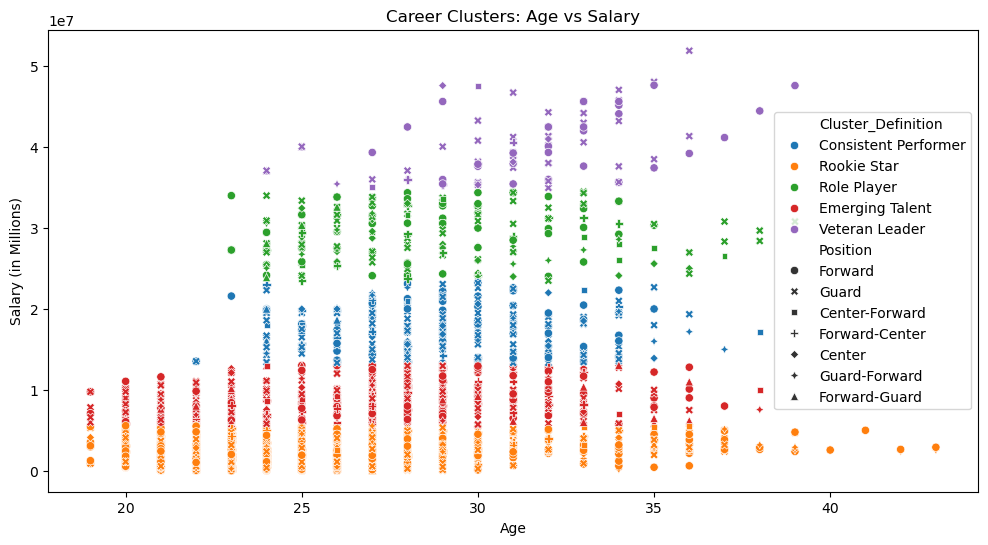

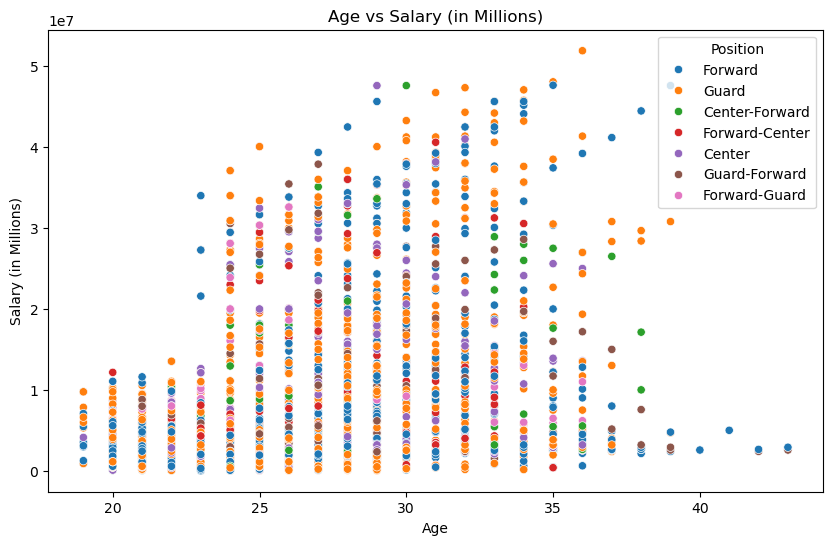

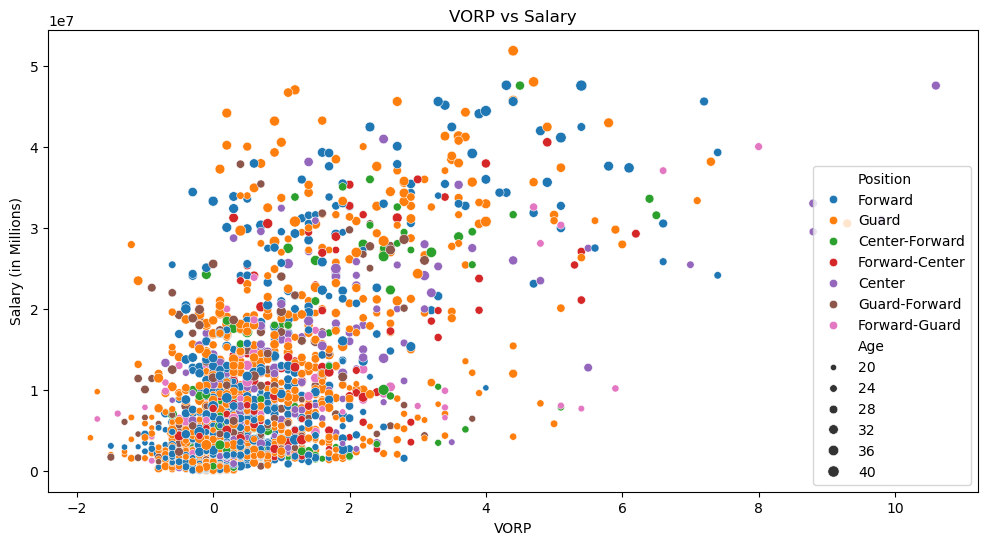

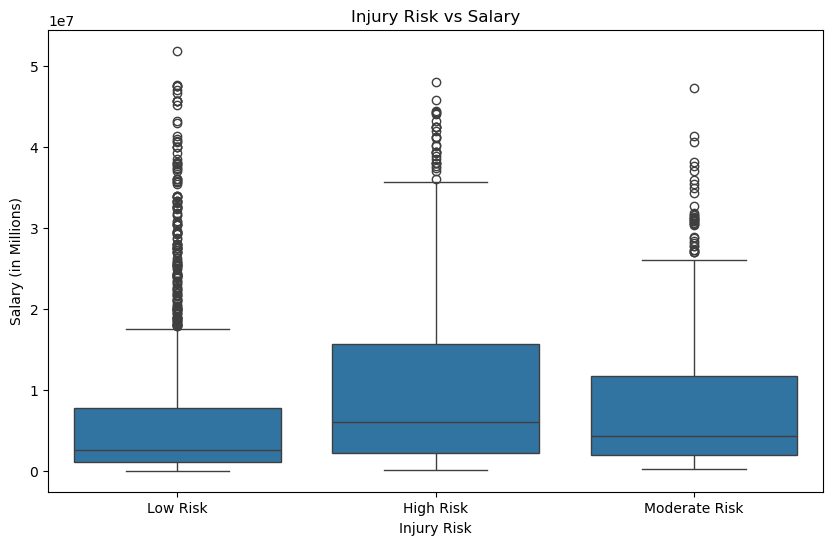

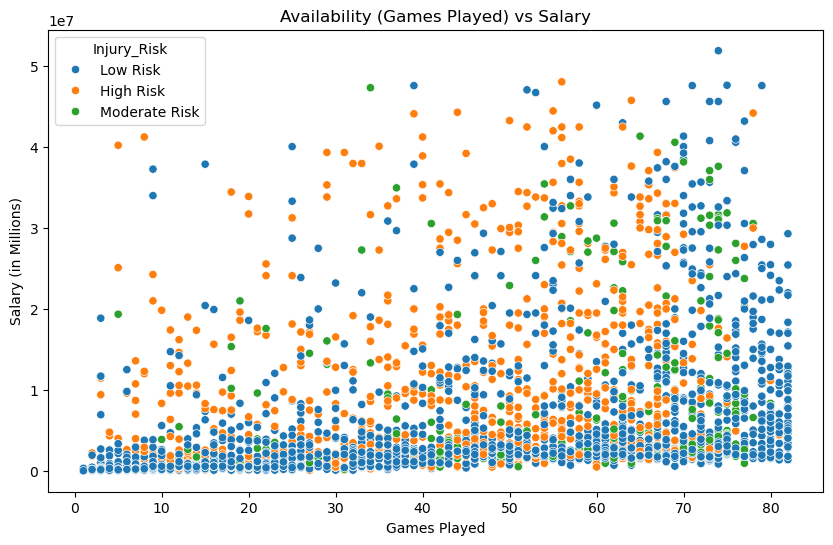

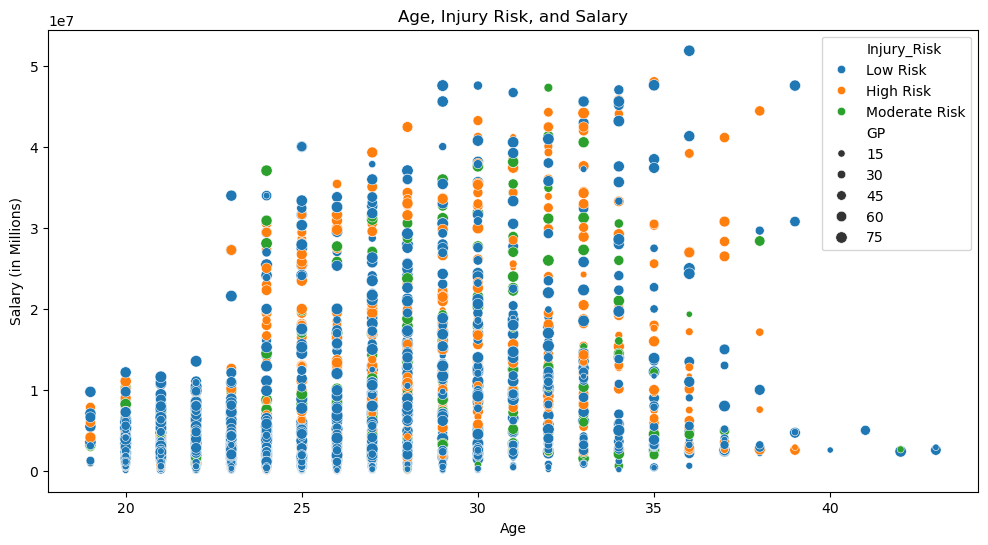

In [10]:
# %%writefile ../src/advanced_metrics.py

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Advanced Analytics functions
def plot_career_clusters(df):
    fig, ax = plt.subplots(figsize=(12, 6))
    sns.scatterplot(x='Age', y='Salary', hue='Cluster_Definition', style='Position', data=df, ax=ax)
    ax.set_title('Career Clusters: Age vs Salary')
    ax.set_xlabel('Age')
    ax.set_ylabel('Salary (in Millions)')
    return fig

def plot_age_vs_salary(df):
    fig, ax = plt.subplots(figsize=(10, 6))
    sns.scatterplot(x='Age', y='Salary', hue='Position', data=df, ax=ax)
    ax.set_title('Age vs Salary (in Millions)')
    ax.set_xlabel('Age')
    ax.set_ylabel('Salary (in Millions)')
    return fig

def plot_vorp_vs_salary(df):
    fig, ax = plt.subplots(figsize=(12, 6))
    sns.scatterplot(x='VORP', y='Salary', hue='Position', size='Age', data=df, ax=ax)
    ax.set_title('VORP vs Salary')
    ax.set_xlabel('VORP')
    ax.set_ylabel('Salary (in Millions)')
    return fig

def plot_injury_risk_vs_salary(df):
    fig, ax = plt.subplots(figsize=(10, 6))
    sns.boxplot(x='Injury_Risk', y='Salary', data=df, ax=ax)
    ax.set_title('Injury Risk vs Salary')
    ax.set_xlabel('Injury Risk')
    ax.set_ylabel('Salary (in Millions)')
    return fig

def plot_availability_vs_salary(df):
    fig, ax = plt.subplots(figsize=(10, 6))
    sns.scatterplot(x='GP', y='Salary', hue='Injury_Risk', data=df, ax=ax)
    ax.set_title('Availability (Games Played) vs Salary')
    ax.set_xlabel('Games Played')
    ax.set_ylabel('Salary (in Millions)')
    return fig

def plot_age_injury_salary(df):
    fig, ax = plt.subplots(figsize=(12, 6))
    sns.scatterplot(x='Age', y='Salary', hue='Injury_Risk', size='GP', data=df, ax=ax)
    ax.set_title('Age, Injury Risk, and Salary')
    ax.set_xlabel('Age')
    ax.set_ylabel('Salary (in Millions)')
    return fig

# Function to cluster players
def cluster_players(df, n_clusters=5):
    df = df.copy()
    
    # Select relevant metrics for clustering
    relevant_metrics = [
        'FG', 'FGA', 'FG%', '3P', '3PA', '3P%', '2P', '2PA', '2P%', 'eFG%', 'FT', 'FTA',
        'FT%', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS',
        'PER', 'TS%', 'ORB%', 'DRB%', 'TRB%', 'AST%', 'STL%', 'BLK%', 'TOV%',
        'USG%', 'OWS', 'DWS', 'WS', 'WS/48', 'OBPM', 'DBPM', 'BPM', 'VORP',
        'Wins', 'Losses', 'Salary'
    ]
    
    df_numeric = df[relevant_metrics].dropna()

    print(f"Clustering players using columns: {df_numeric.columns}")
    kmeans = KMeans(n_clusters=n_clusters, random_state=0)
    
    # Fit the model and predict clusters
    clusters = kmeans.fit_predict(df_numeric)
    
    # Create a new DataFrame with the relevant metrics to maintain the same index as the original DataFrame
    df_clustered = df.loc[df_numeric.index]
    df_clustered['Cluster'] = clusters
    
    # Mapping cluster numbers to descriptive names
    cluster_names = {
        0: "Rookie Star",
        1: "Veteran Leader",
        2: "Consistent Performer",
        3: "Emerging Talent",
        4: "Role Player"
    }
    df_clustered['Cluster_Definition'] = df_clustered['Cluster'].map(cluster_names)
    
    # Merging the cluster information back to the original DataFrame
    df = df.merge(df_clustered[['Cluster', 'Cluster_Definition']], left_index=True, right_index=True, how='left')
    
    return df

# Main function to test advanced metrics
def main():
    # Sample data loading
    data = pd.read_csv('../data/processed/nba_player_data_final_inflated.csv')

    # Clustering players
    data = cluster_players(data, n_clusters=5)

    # Testing Career Clusters plot
    fig1 = plot_career_clusters(data)
    plt.show(fig1)

    # Testing Age vs Salary plot
    fig2 = plot_age_vs_salary(data)
    plt.show(fig2)

    # Testing VORP vs Salary plot
    fig3 = plot_vorp_vs_salary(data)
    plt.show(fig3)

    # Testing Injury Risk vs Salary plot
    fig4 = plot_injury_risk_vs_salary(data)
    plt.show(fig4)

    # Testing Availability (Games Played) vs Salary plot
    fig5 = plot_availability_vs_salary(data)
    plt.show(fig5)

    # Testing Age, Injury Risk, and Salary combined plot
    fig6 = plot_age_injury_salary(data)
    plt.show(fig6)

if __name__ == "__main__":
    main()


In [11]:
%%writefile ../src/app.py

import os
import streamlit as st
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import joblib
import plotly.graph_objects as go
from datetime import datetime
from nba_api.stats.static import teams, players

# Import functions from other modules
from data_loader_preprocessor import load_data, format_season, clean_data, engineer_features, encode_data
from model_trainer import train_and_save_models, evaluate_models
from model_predictor import predict

# Import functions from app_test_trade_impact.py
from app_test_trade_impact import analyze_trade_impact, get_players_for_team

# Importing Shot Chart Analysis functions
from shot_chart.nba_helpers import get_team_abbreviation, categorize_shot, get_all_court_areas
from shot_chart.nba_shots import fetch_shots_data, fetch_defensive_shots_data, fetch_shots_for_multiple_players
from shot_chart.nba_plotting import plot_shot_chart_hexbin
from shot_chart.nba_efficiency import create_mae_table, save_mae_table, load_mae_table, get_seasons_range, calculate_compatibility_between_players
from shot_chart.shot_chart_main import run_scenario, preload_mae_tables, create_and_save_mae_table_specific, create_and_save_mae_table_all

@st.cache_data
def get_teams_list():
    """Get the list of NBA teams."""
    return [team['full_name'] for team in teams.get_teams()]

@st.cache_data
def get_players_list():
    """Get the list of NBA players."""
    return [player['full_name'] for player in players.get_players()]

@st.cache_data
def load_team_data():
    nba_teams = teams.get_teams()
    team_df = pd.DataFrame(nba_teams)
    return team_df[['id', 'full_name', 'abbreviation']]

@st.cache_data
def load_player_data(start_year, end_year):
    player_data = pd.DataFrame()
    for year in range(start_year, end_year + 1):
        data = fetch_season_data_by_year(year)
        if data is not None:
            player_data = pd.concat([player_data, data], ignore_index=True)
    return player_data

def identify_overpaid_underpaid(predictions_df):
    # Adjust Predicted_Salary calculation
    predictions_df['Predicted_Salary'] = predictions_df['Predicted_Salary'] * predictions_df['Salary_Cap_Inflated']
    
    predictions_df['Salary_Difference'] = predictions_df['Salary'] - predictions_df['Predicted_Salary']
    predictions_df['Overpaid'] = predictions_df['Salary_Difference'] > 0
    predictions_df['Underpaid'] = predictions_df['Salary_Difference'] < 0
    
    overpaid = predictions_df[predictions_df['Overpaid']].sort_values('Salary_Difference', ascending=False)
    underpaid = predictions_df[predictions_df['Underpaid']].sort_values('Salary_Difference')
    
    return overpaid.head(10), underpaid.head(10)

# Utility functions
def load_processed_data(file_path):
    data = load_data(file_path)
    data = format_season(data)
    data = clean_data(data)
    data = engineer_features(data)
    return data

def filter_data_by_season(data, season):
    return data[data['Season'] == season]

# Data visualization functions
def plot_feature_distribution(data, feature):
    fig, ax = plt.subplots(figsize=(10, 6))
    sns.histplot(data[feature], kde=True, ax=ax)
    ax.set_title(f'Distribution of {feature}')
    ax.set_xlabel(feature)
    ax.set_ylabel('Count')
    return fig

def plot_correlation_heatmap(data):
    numeric_data = data.select_dtypes(include=[np.number])
    corr = numeric_data.corr()
    fig, ax = plt.subplots(figsize=(12, 10))
    sns.heatmap(corr, annot=False, cmap='coolwarm', ax=ax)
    ax.set_title('Correlation Heatmap')
    return fig

# Model metrics function
def display_model_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    st.subheader("Model Performance Metrics")
    col1, col2, col3, col4 = st.columns(4)
    col1.metric("Mean Squared Error", f"{mse:.4f}")
    col2.metric("Root Mean Squared Error", f"{rmse:.4f}")
    col3.metric("Mean Absolute Error", f"{mae:.4f}")
    col4.metric("R-squared", f"{r2:.4f}")

def display_overpaid_underpaid(predictions_df):
    st.subheader("Top 10 Overpaid and Underpaid Players")

    # Add filters
    col1, col2 = st.columns(2)
    with col1:
        team_filter = st.multiselect("Filter by Team", options=sorted(predictions_df['Team'].unique()))
    with col2:
        position_filter = st.multiselect("Filter by Position", options=sorted(predictions_df['Position'].unique()))

    # Apply filters
    filtered_df = predictions_df
    if team_filter:
        filtered_df = filtered_df[filtered_df['Team'].isin(team_filter)]
    if position_filter:
        filtered_df = filtered_df[filtered_df['Position'].isin(position_filter)]

    # Identify overpaid and underpaid players
    overpaid, underpaid = identify_overpaid_underpaid(filtered_df)

    col1, col2 = st.columns(2)
    with col1:
        st.subheader("Top 10 Overpaid Players")
        st.dataframe(overpaid[['Player', 'Team', 'Position', 'Salary', 'Predicted_Salary', 'Salary_Difference']])

    with col2:
        st.subheader("Top 10 Underpaid Players")
        st.dataframe(underpaid[['Player', 'Team', 'Position', 'Salary', 'Predicted_Salary', 'Salary_Difference']])


# Trade Impact Simulator function
def display_trade_impact(results, team_a_name, team_b_name):
    st.subheader(f"Percentile Counts Impact on {team_a_name} Compared to Average Champion Percentiles")
    st.table(results['celtics_comparison_table'])

    st.subheader(f"Percentile Counts Impact on {team_b_name} Compared to Average Champion Percentiles")
    st.table(results['warriors_comparison_table'])

    st.subheader("Pre vs Post Trade Impact")
    st.table(results['overall_comparison'])

    st.subheader("Salary Analysis: Overpaid vs Underpaid")
    st.table(results['salary_analysis'])

    st.subheader("Salary Cap Clearance: (debug shows Salary cap vs Salary Help)")
    st.write(results['trade_scenario_results'])



def trade_impact_simulator():
    st.header("Trade Impact Simulator")

    teams = load_team_data()
    team_a_name = st.selectbox("Select Team A", teams['full_name'])
    team_b_name = st.selectbox("Select Team B", teams['full_name'][teams['full_name'] != team_a_name].tolist())

    players_from_team_a = st.multiselect(f"Select Players from {team_a_name}", get_players_for_team(team_a_name))
    players_from_team_b = st.multiselect(f"Select Players from {team_b_name}", get_players_for_team(team_b_name))

    trade_date = st.date_input("Trade Date", value=pd.to_datetime("2023-12-20"))

    percentile_seasons = st.multiselect("Select Average Champion Comparison Percentiles Seasons (default: 10):", 
                                        ["2014-15", "2015-16", "2016-17", "2017-18", 
                                         "2018-19", "2019-20", "2020-21", "2021-22", "2022-23", "2023-24"],
                                        default=["2014-15", "2015-16", "2016-17", "2017-18", 
                                         "2018-19", "2019-20", "2020-21", "2021-22", "2022-23", "2023-24"])

    if st.button("Simulate Trade Impact"):
        if players_from_team_a and players_from_team_b:
            traded_players = {player: team_a_name for player in players_from_team_a}
            traded_players.update({player: team_b_name for player in players_from_team_b})

            # Call the analysis function and capture the results
            results = analyze_trade_impact(traded_players, trade_date.strftime('%Y-%m-%d'), percentile_seasons, debug=True)

            if results:
                # Display all results in the app
                display_trade_impact(results, team_a_name, team_b_name)

                # MAE Analysis section
                st.subheader("Player Shooting Area Compatibility (MAE Analysis)")

                # Combine the players from both teams
                all_players = players_from_team_a + players_from_team_b

                # Fetch shots for the selected players
                player_shots = fetch_shots_for_multiple_players(all_players, season='2023-24', court_areas='all')

                # Calculate compatibility
                compatibility_df = calculate_compatibility_between_players(player_shots)

                # Display the MAE table
                st.write(compatibility_df)

                # Salary Cap Clearance section
                st.subheader("Salary Cap Clearance: (debug shows Salary cap vs Salary Help)")
                st.write(results['trade_scenario_results'])

                # Display debug output
                st.subheader("Debug Information")
                st.text_area("Detailed Debug Output", results['trade_scenario_debug'], height=300)

                st.success("Trade Impact Simulation Completed")
            else:
                st.error("Trade impact analysis failed. Please check the inputs.")
        else:
            st.error("Please select players from both teams to simulate the trade impact.")


# Shot Chart Analysis function
def shot_chart_analysis():
    st.header("Shot Chart Analysis")

    # Add guidelines and purpose explanation at the top
    st.markdown("""
    ### Welcome to the NBA Shot Analysis App!
    
    This app allows you to analyze the offensive and defensive efficiency of NBA teams and players. 
    You can compare players or teams to identify the most efficient spots on the court, 
    analyze player compatibility based on shot area efficiency, and much more.
    
    **Options and Guidelines:**
    - **Analysis Type**: Choose between offensive, defensive, or both types of analysis.
    - **Team or Player**: Analyze a team or an individual player.
    - **Court Areas**: Select specific court areas or analyze all areas.
    - **Comparison**: Compare multiple players to see how their offensive efficiencies align or differ.
    """)

    analysis_type = st.selectbox("Select analysis type", options=["offensive", "defensive", "both"])

    entity_type = st.selectbox("Analyze a Team or Player?", options=["team", "player"])

    if entity_type == "team":
        st.markdown("_**Team option is able to analyze both offense and defense by looking into the defense by shot detail from other teams' shot charts against the Opposing Team.**_")
        entity_name = st.selectbox("Select a Team", options=get_teams_list())
    else:
        st.markdown("_**Player Option is only able to look at offense.**_")
        player_names = st.multiselect("Select Players to Analyze", options=get_players_list())

    season = st.selectbox("Select the season", options=["2023-24", "2022-23", "2021-22", "2020-21"])

    opponent_type = st.selectbox("Compare against all teams or a specific team?", options=["all", "specific"])

    opponent_name = None
    if opponent_type == "specific":
        opponent_name = st.selectbox("Select an Opponent Team", options=get_teams_list())

    court_areas = st.selectbox("Select court areas to analyze", options=["all", "specific"], index=0)

    if court_areas == "specific":
        court_areas = st.multiselect("Select specific court areas", options=get_all_court_areas())
    else:
        court_areas = "all"

    debug_mode = st.checkbox("Enable Debug Mode", value=False)

    if st.button("Run Analysis"):
        if entity_type == "player" and (not player_names or len(player_names) < 1):
            st.error("Please select at least one player.")
        else:
            if entity_type == "player":
                if len(player_names) == 1:
                    # Single player analysis
                    run_scenario(
                        entity_name=player_names[0],
                        entity_type=entity_type,
                        season=season,
                        opponent_name=opponent_name,
                        analysis_type=analysis_type,
                        compare_players=False,
                        player_names=None,
                        court_areas=court_areas
                    )
                else:
                    # Multiple players comparison
                    player_shots = fetch_shots_for_multiple_players(player_names, season, court_areas, opponent_name, debug=debug_mode)

                    for player, shots in player_shots.items():
                        st.pyplot(plot_shot_chart_hexbin(shots['shots'], f'{player} Shot Chart', opponent=opponent_name if opponent_name else "all teams"))
                        st.write(f"Efficiency for {player}:")
                        st.write(shots['efficiency'])

                    compatibility_df = calculate_compatibility_between_players(player_shots)
                    st.write("Player Shooting Area Compatibility:")
                    st.write(compatibility_df)
            else:
                # Team analysis
                run_scenario(
                    entity_name=entity_name,
                    entity_type=entity_type,
                    season=season,
                    opponent_name=opponent_name,
                    analysis_type=analysis_type,
                    compare_players=False,
                    court_areas=court_areas
                )

    # Add explanation for shot chart MAE analysis
    with st.expander("Understanding MAE in Player Analysis with context from their Shooting"):
        st.markdown("""
        **MAE** is a metric that measures the average magnitude of errors between predicted values and actual values, without considering their direction.
        
        In our context, MAE is used to measure the difference between the shooting efficiencies of two players across various areas on the court.
        
        **Steps to Analyze MAE:**
        1. **Define Common Areas**: The court is divided into areas like "Left Corner 3", "Top of Key", "Paint", etc.
        2. **Calculate Individual Efficiencies**: Fetch shot data for each player and calculate their shooting efficiency in these areas.
        3. **Identify Common Areas**: When comparing players, identify the areas where both players have taken shots.
        4. **Calculate MAE**: Compute the absolute difference between efficiencies in each common area and average them.
        5. **Interpret Compatibility**:
            - **High MAE**: Indicates players excel in different areas (more compatible).
            - **Low MAE**: Indicates similar efficiencies in the same areas (less compatible).
        
        **Use this metric to assess player compatibility based on where they excel on the court!**
        """)

    with st.expander("Understanding MAE in Team (offensive or defensive) in comparison to other Teams"):
        st.markdown("""
        **MAE** is a metric that measures the average magnitude of errors between predicted values and actual values, without considering their direction.
        
        In the context of team analysis, MAE is used to measure the difference between the shooting efficiencies of one team's offense and the defensive efficiencies of other teams.
        
        **Steps to Analyze MAE for Team Comparison:**
        1. **Calculate Offensive Efficiency**: Fetch shot data for the team of interest and calculate their shooting efficiency across various areas on the court.
        2. **Calculate Defensive Efficiency of Opponents**: For each opponent team, calculate their defensive efficiency by analyzing how well they defend these same areas on the court.
        3. **Calculate MAE**: Compute the MAE between the offensive efficiency of the team of interest and the defensive efficiencies of each opponent team across the defined court areas.
        4. **Interpret the Results**:
            - **Low MAE**: Indicates that the opponent team is effective at defending the areas where the team of interest typically excels. This suggests that the opponent is a "bad fit" for the team of interest, as they defend well against their strengths.
            - **High MAE**: Indicates that the opponent team struggles to defend the areas where the team of interest typically excels. This suggests that the opponent is a "good fit" for the team of interest, as their defense is less effective against the team's offensive strengths.
        
        **Use this analysis to identify which teams are tough matchups (bad fits) versus easier matchups (good fits) based on how well they can defend your team's key offensive areas!**
        """)

# Main Streamlit app
def main():
    st.set_page_config(page_title="NBA Salary Prediction, Trade Analysis, and Shot Chart Analysis", layout="wide")
    st.title("NBA Salary Prediction, Trade Analysis, and Shot Chart Analysis")

    # Sidebar navigation
    st.sidebar.title("Navigation")
    page = st.sidebar.radio("Go to", ["Data Analysis", "Model Results", "Salary Evaluation", "Trade Impact Simulator", "Shot Chart Analysis"])

    # Load base data
    print(os.getcwd())
    data = load_processed_data('data/processed/nba_player_data_final_inflated.csv')

    # Load existing predictions for 2023
    initial_predictions_df = pd.read_csv('data/processed/predictions_df.csv')

    # Season selection
    seasons = sorted(data['Season'].unique(), reverse=True)
    selected_season = st.selectbox("Select Season", seasons)

    # Load models at the beginning of main()
    model_save_path = 'data/models'
    rf_model = joblib.load(f"{model_save_path}/best_rf_model.pkl")
    xgb_model = joblib.load(f"{model_save_path}/best_xgb_model.pkl")

    # Use initial predictions if 2023 is selected, otherwise retrain
    if selected_season == 2023:
        predictions_df = initial_predictions_df
    else:
        # Train model and make predictions
        train_data = data[data['Season'] < selected_season]
        test_data = data[data['Season'] == selected_season]

        # Prepare the data for training
        X_train = train_data.drop(['SalaryPct', 'Salary', 'Player'], axis=1)
        y_train = train_data['SalaryPct']

        # Encode the training data
        X_train_encoded, _, encoders, scaler, numeric_cols, player_encoder = encode_data(X_train)

        # Train and save models
        train_and_save_models(X_train_encoded, y_train, model_save_path, scaler, X_train_encoded.columns, encoders, player_encoder, numeric_cols)

        # Make predictions on the test data
        predictions_df = predict(test_data, model_save_path)

    if page == "Data Analysis":
        st.header("Data Analysis")

        # Filter data by selected season
        season_data = filter_data_by_season(data, selected_season)

        # Display basic statistics
        st.subheader("Basic Statistics")
        st.write(season_data.describe())

        # Feature distribution
        st.subheader("Feature Distribution")
        feature = st.selectbox("Select Feature", season_data.columns)
        fig = plot_feature_distribution(season_data, feature)
        st.pyplot(fig)

        # Correlation heatmap
        st.subheader("Correlation Heatmap")
        fig = plot_correlation_heatmap(season_data)
        st.pyplot(fig)

        # Data handling explanation
        st.subheader("Data Handling")
        st.write("""
        We preprocessed the data to ensure it's suitable for our models:
        1. Cleaned missing values and outliers
        2. Engineered new features like PPG, APG, etc.
        3. Encoded categorical variables (Position, Team, Injury Risk)
        4. Scaled numerical features
        """)

    elif page == "Model Results":
        st.header("Model Results")

        # Model selection
        model_choice = st.selectbox("Select Model", ["Random Forest", "XGBoost"])

        if model_choice == "Random Forest":
            model = rf_model
            y_pred = predictions_df['RF_Predictions']
        else:
            model = xgb_model
            y_pred = predictions_df['XGB_Predictions']

        # Display model metrics
        display_model_metrics(predictions_df['SalaryPct'], y_pred)

        # Feature importance
        st.subheader("Feature Importance")
        feature_importance = pd.DataFrame({
            'feature': model.feature_names_in_,
            'importance': model.feature_importances_
        }).sort_values('importance', ascending=False)
        print("Features used in the model:", model.feature_names_in_)  # Debug statement
        print("Feature importance data:", feature_importance.head())  # Debug statement
        # Filter out categorical variables (e.g., Position_ and Team_ columns)
        filtered_feature_importance = feature_importance[
            ~feature_importance['feature'].str.startswith('Team_') &
            ~feature_importance['feature'].str.startswith('Position_') &
            ~feature_importance['feature'].str.startswith('Injury_Risk')
        ]

        # Before plotting feature importance
        print("Filtered features for plotting:", filtered_feature_importance['feature'].tolist())  # Debug statement
        st.bar_chart(filtered_feature_importance.set_index('feature'))


        # Model explanation
        st.subheader("Model Explanation")
        st.write(f"""
        The {model_choice} model was trained on historical NBA player data to predict salary percentages.
        We used the following techniques to improve model performance:
        1. Feature engineering to create relevant statistics
        2. Proper encoding of categorical variables
        3. Scaling of numerical features
        4. Hyperparameter tuning using GridSearchCV
        """)
        
    elif page == "Salary Evaluation":
        st.header("Salary Evaluation")
        display_overpaid_underpaid(predictions_df)
        st.write("""
        Using the Predicted Salary and Salary based on that season's stats, we can identify 
        overpaid and underpaid players. We find the difference to uncover potential value opportunities for different teams.
        """)
        
    elif page == "Trade Impact Simulator":
        trade_impact_simulator()
        
        # Trade analysis explanation
        st.subheader("Trade Analysis Explanation")
        st.write("""
        Our trade analysis compares team statistics before and after the proposed trade.
        We consider:
        1. Changes in key performance metrics (PPG, RPG, APG, etc.)
        2. Salary implications and cap space impact
        3. Comparison to league averages and recent championship teams
        4. Distribution of top performers in various statistical categories
        5. Overpaid/Underpaid player analysis
        """)

    elif page == "Shot Chart Analysis":
        shot_chart_analysis()

if __name__ == "__main__":
    main()


Overwriting ../src/app.py
